In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Add the root directory of the package to sys.path
sys.path.append('/Users/zzhang/Workspace/SpyDust/')

import SpyDust.Grain as spyGrain
from SpyDust.util import cgsconst

import SpyDust
import SpyDust.SPDUST_as_is.spdust as spdust
import SpyDust.SPDUST_as_is.grain_properties as spdust_grain

l_a computed
readPAH computed
Loaded previously computed Jpeisrf arrays from file.
Tev table already exists at /Users/zzhang/Workspace/SpyDust/SpyDust/Data_Files/Tev_30a_30chi.txt.
I(Zg<0, parabolic) stored
I(rot, e, Zg <> 0) stored
I(Zg<0, parabolic) stored
I(rot, e, Zg <> 0) stored
Gaunt factor stored
l_a computed
readPAH computed
Loaded previously computed Jpeisrf arrays from file.
Maximum energy in the Qabs_hnu_tab is 1239.84 eV.
FIR_integral_charged shape: (30, 30)
Na: 30, Nchi: 30
Tev table already exists at /Users/zzhang/Workspace/SpyDust/SpyDust/Data_Files/Tev_30a_30chi.txt.
Gaunt factor stored


/Users/zzhang/Workspace/SpyDust/SpyDust/free_free.py:27: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(gff_data_file, delim_whitespace=True, comment=';', header=None, names=['gamma2', 'u', 'gff'])
/Users/zzhang/Workspace/SpyDust/SpyDust/SPDUST_as_is/emissivity.py:441: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(gff_data_file, delim_whitespace=True, comment=';', header=None, names=['gamma2', 'u', 'gff'])


Environment parameters

In [2]:
DC_params = {'nh' : 1e4, 'T': 10., 'Chi': 1e-4, 'xh': 0., 'xC': 1e-6, 'y' : 0.999,  'gamma': 0, 'dipole': 9.3, 'line':7}

MC_params = {'nh' : 3e2, 'T': 20., 'Chi': 1e-2, 'xh': 0., 'xC': 1e-4, 'y' : 0.99,  'gamma': 0, 'dipole': 9.3, 'line':7}    

CNM_params = {'nh' : 30, 'T': 100., 'Chi': 1, 'xh': 1.2e-3, 'xC': 3e-4, 'y' : 0, 'gamma': 0, 'dipole': 9.3, 'line':7}

WNM_params = {'nh' : 0.4, 'T': 6000., 'Chi': 1., 'xh': 0.1, 'xC': 3e-4, 'y' : 0, 'gamma': 0, 'dipole': 9.3, 'line':7}

WIM_params = {'nh' : 0.1, 'T': 8000., 'Chi': 1., 'xh': 0.99, 'xC': 1e-3, 'y' : 0, 'gamma': 0, 'dipole': 9.3, 'line':7}

RN_params = {'nh' : 1000., 'T': 100., 'Chi': 1000., 'xh': 0.001, 'xC': 2e-4, 'y' : 0.5, 'gamma': 0, 'dipole': 9.3, 'line':7}

PDR_params = {'nh' : 1e5, 'T': 300., 'Chi': 3000., 'xh': 0.0001, 'xC': 2e-4, 'y' : 0.5, 'gamma': 0, 'dipole': 9.3, 'line':7}

In [3]:
grain_obj = spyGrain.grain_distribution()
f_a_beta = grain_obj.shape_and_size_dist(6, a_weighted=True, normalize=False, fixed_thickness=True)
a_tab = grain_obj.a_tab
# SpyDust
a2 = spyGrain.grainparams.a2
d = spyGrain.grainparams.d

def beta_a(i):
    a = a_tab[i]
    if a > a2:
        return 0
    else:
        return spyGrain.cylindrical_params(a, d)[1]
    
beta_a_list = [beta_a(i) for i in range(len(a_tab))]

In [4]:
spy_color1, spy_color2, spdust_color1, spdust_color2=['#9ED17B', '#367DB0', '#A8ACCB', '#AC8AB3']

### Correction of the dipole radiation backreaction

In [5]:
debye = cgsconst.debye

import SpyDust.charge_dist as spy_charge_dist
import SpyDust.AngMomDist as spyAngMomDist

dip_per_at = WNM_params['dipole'] / np.sqrt(spyGrain.N_C(1e-7) + spyGrain.N_H(1e-7)) * debye

spy_fZ = [spy_charge_dist.charge_dist(WNM_params, a_tab[i], beta_a_list[i]) for i in range(len(a_tab)) ]
spy_Z2 = [np.sum(spy_fZ[i][0, :]**2 * spy_fZ[i][1, :]) for i in range(len(a_tab))]
spy_mu_rms = [spyGrain.rms_dipole(a_tab[i], beta_a_list[i], spy_Z2[i], dip_per_at) for i in range(len(a_tab))]
ip=2/3
spy_mu_ip = [spy_mu_rms[i]*np.sqrt(ip) for i in range(len(a_tab))]
spy_mu_op = [spy_mu_rms[i]*np.sqrt(1-ip) for i in range(len(a_tab))]
spy_tau_ed_inv = [spyAngMomDist.tau_ed_inv(WNM_params['T'], a_tab[i], beta_a_list[i], spy_mu_ip[i], spy_mu_op[i], tumbling=True) for i in range(len(a_tab))]

In [6]:
import SpyDust.SPDUST_as_is.charge_dist as spdust_charge_dist
import SpyDust.SPDUST_as_is.emissivity as spdust_emissivity

SPD_fZ = [spdust_charge_dist.charge_dist(WNM_params, a_tab[i]) for i in range(len(a_tab)) ]
SPD_Z2 = [np.sum(SPD_fZ[i][0, :]**2 * SPD_fZ[i][1, :]) for i in range(len(a_tab))]
SPD_mu_rms = [spdust_grain.rms_dipole(a_tab[i], SPD_Z2[i], dip_per_at) for i in range(len(a_tab))]
ip=2/3
SPD_mu_ip = [SPD_mu_rms[i]*np.sqrt(ip) for i in range(len(a_tab))]
SPD_mu_op = [SPD_mu_rms[i]*np.sqrt(1-ip) for i in range(len(a_tab))]
SPD_tau_ed_inv = [spdust_emissivity.tau_ed_inv(WNM_params, a_tab[i], SPD_mu_ip[i], SPD_mu_op[i], tumbling=True) for i in range(len(a_tab))]

Text(0.5, 1.0, 'RMS dipole moment')

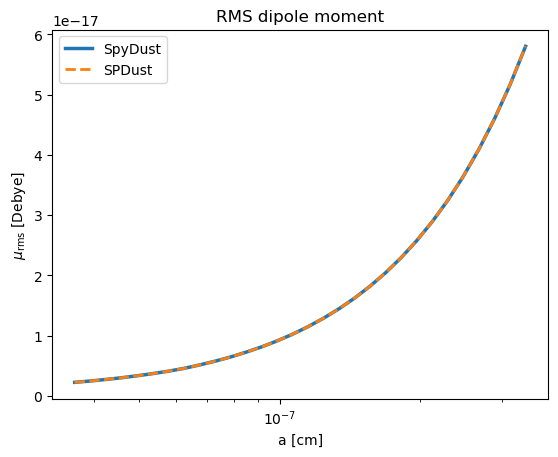

In [7]:
# Compare rms dipole moments
plt.plot(a_tab, spy_mu_rms, label='SpyDust', ls='-', color='C0', lw=2.5)
plt.plot(a_tab, SPD_mu_rms, label='SPDust', ls='--', color='C1', lw=2)
plt.xscale('log')
plt.legend()
plt.xlabel('a [cm]')
plt.ylabel(r'$\mu_{\rm rms}$ [Debye]')
plt.title('RMS dipole moment')

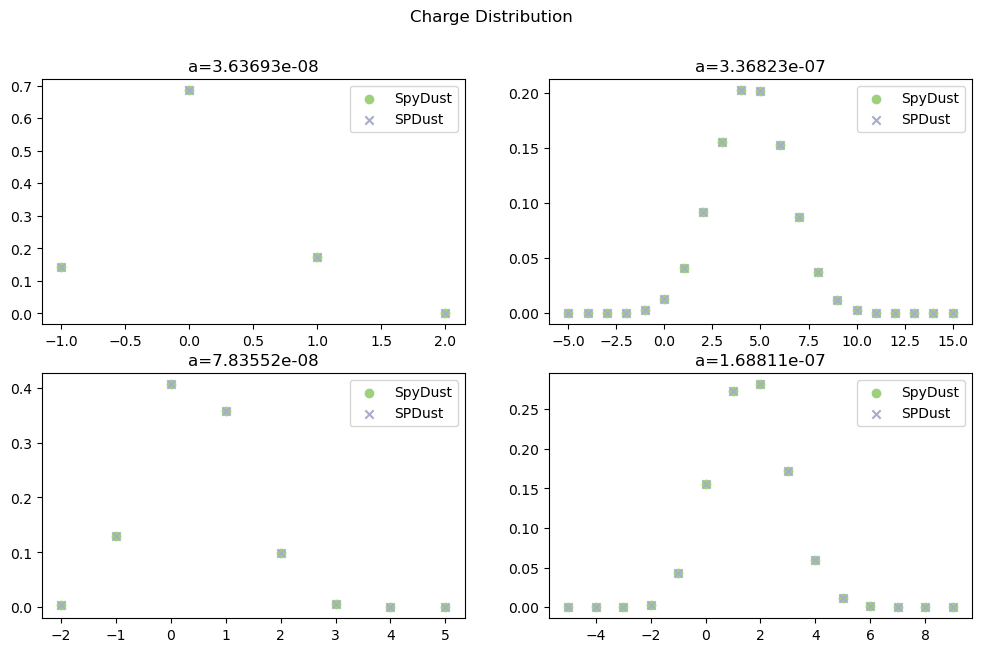

In [8]:
# Compare the charge distribution

fig = plt.figure(figsize=(12, 7))
gs = GridSpec(2, 2, figure=fig)

ax1 = fig.add_subplot(gs[0, 0])
ax1.scatter(spy_fZ[0][0, :], spy_fZ[0][1, :], label='SpyDust', color=spy_color1)
ax1.scatter(SPD_fZ[0][0, :], SPD_fZ[0][1, :], label='SPDust', marker='x', color=spdust_color1)
ax1.title.set_text('a={:2g}'.format(a_tab[0]))

ax2 = fig.add_subplot(gs[0, 1])
ax2.scatter(spy_fZ[-1][0, :], spy_fZ[-1][1, :], label='SpyDust', color=spy_color1)
ax2.scatter(SPD_fZ[-1][0, :], SPD_fZ[-1][1, :], label='SPDust', marker='x', color=spdust_color1)
ax2.title.set_text('a={:2g}'.format(a_tab[-1]))

ax3 = fig.add_subplot(gs[1, 0])
ax3.scatter(spy_fZ[10][0, :], spy_fZ[10][1, :], label='SpyDust', color=spy_color1)
ax3.scatter(SPD_fZ[10][0, :], SPD_fZ[10][1, :], label='SPDust', marker='x', color=spdust_color1)
ax3.title.set_text('a={:2g}'.format(a_tab[10]))

ax4 = fig.add_subplot(gs[1, 1])
ax4.scatter(spy_fZ[20][0, :], spy_fZ[20][1, :], label='SpyDust', color=spy_color1)
ax4.scatter(SPD_fZ[20][0, :], SPD_fZ[20][1, :], label='SPDust', marker='x', color=spdust_color1)
ax4.title.set_text('a={:2g}'.format(a_tab[20]))

ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()

#plt.title('Charge Distribution')
fig.suptitle('Charge Distribution')
plt.show()


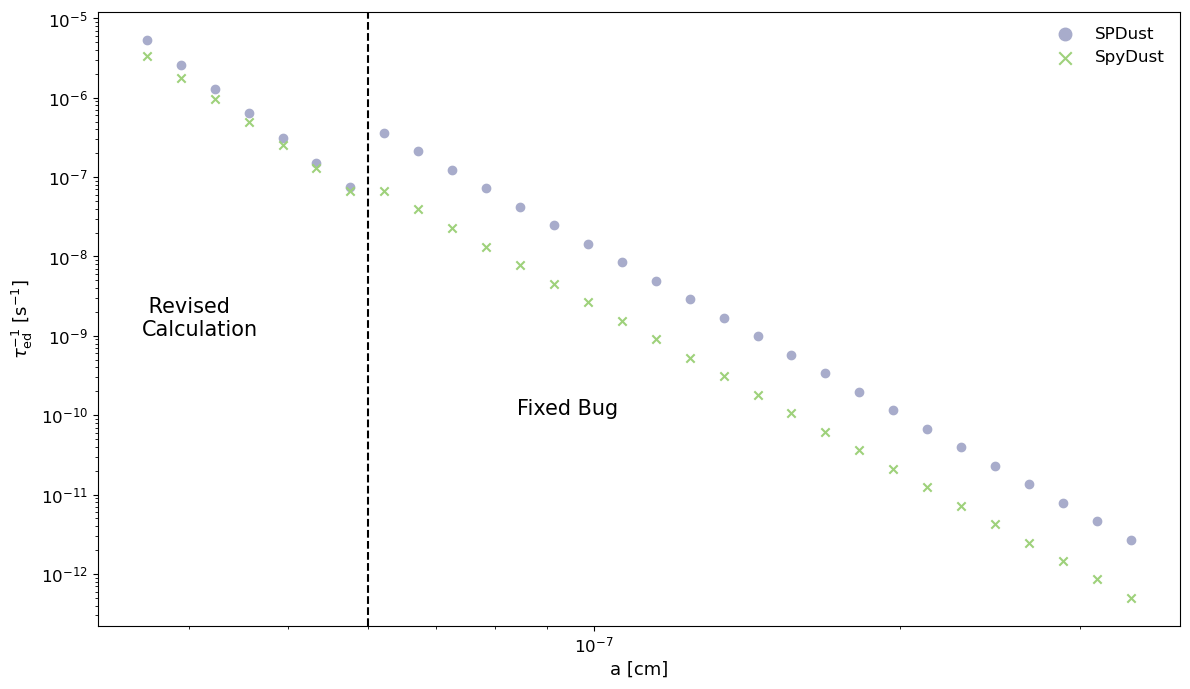

In [9]:
SPD_tau_ed_inv = np.array(SPD_tau_ed_inv)
spy_tau_ed_inv = np.array(spy_tau_ed_inv)
fig = plt.figure(figsize=(12, 7))
plt.scatter(a_tab, SPD_tau_ed_inv, label='SPDust', color=spdust_color1)
plt.scatter(a_tab, spy_tau_ed_inv, label='SpyDust', lw=1.5, marker='x', color=spy_color1)
plt.xscale('log')
plt.yscale('log')
# plot vertical line at a2
plt.axvline(a2, color='k', ls='--')
# add text to the left of the line
plt.text(a2*0.6, 1e-9, ' Revised\nCalculation', fontsize=15)
plt.text(a2*1.4, 1e-10, 'Fixed Bug', fontsize=15)
plt.legend(fontsize=12, loc='upper right', markerscale=1.5, frameon=False)
plt.xlabel('a [cm]', fontsize=13)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel(r'$\tau_{\rm ed}^{-1}$ [s$^{-1}$]', fontsize=13)
plt.tight_layout()
plt.savefig('figures/tau_ed_inv_comparison.pdf')

In [7]:
dip_per_at = WIM_params['dipole'] / np.sqrt(spyGrain.N_C(1e-7) + spyGrain.N_H(1e-7)) * debye

spy_fZ = [spy_charge_dist.charge_dist(WIM_params, a_tab[i], beta_a_list[i]) for i in range(len(a_tab)) ]
spy_Z2 = [np.sum(spy_fZ[i][0, :]**2 * spy_fZ[i][1, :]) for i in range(len(a_tab))]
spy_mu_rms = [spyGrain.rms_dipole(a_tab[i], beta_a_list[i], spy_Z2[i], dip_per_at) for i in range(len(a_tab))]
ip=2/3
mu_ip = [spy_mu_rms[i]*np.sqrt(ip) for i in range(len(a_tab))]
mu_op = [spy_mu_rms[i]*np.sqrt(1-ip) for i in range(len(a_tab))]

### Correction of the plasma drag

In [8]:
from SpyDust.plasmadrag import FGp_averaged as spy_FGp_averaged
from SpyDust.SPDUST_as_is.plasmadrag import FGp_averaged as SPD_FGp_averaged
from SpyDust.util import makelogtab

aux_omega_min, aux_omega_max, Nomega = 1e8, 1e15, 1000
aux_omega = makelogtab(aux_omega_min, aux_omega_max, Nomega) 

def plasma_drag_plots(axis, env, ind, title, plot_xlable=True, label=False):
    aux_spy = spy_FGp_averaged(env, a_tab[ind], beta_a_list[ind], spy_fZ[ind], aux_omega, mu_ip[ind], mu_op[ind], tumbling=True)
    spy_Fp = aux_spy['Fp']
    spy_Gp = aux_spy['Gp']
    aux_SPD = SPD_FGp_averaged(env, a_tab[ind], spy_fZ[ind], aux_omega, mu_ip[ind], mu_op[ind], tumbling=True)
    SPD_Fp = aux_SPD['Fp']
    # SPD_Gp = aux_SPD['Gp']
    
    # Compare the plasma drag Fp's and Gp's
    if label:
        axis.loglog(aux_omega, spy_Gp[:,0], label='Fluctuation rate', ls='-', color="gray")
        axis.loglog(aux_omega, SPD_Fp[:,0], label='Drift rate (spdust)', ls=':', lw=2.5, color=spdust_color2)
        axis.loglog(aux_omega, spy_Fp[:,0], label='Drift rate (SpyDust)', ls='--', lw=2, color=spy_color1)
    else:
        axis.loglog(aux_omega, spy_Gp[:,0], ls='-', color="gray")
        axis.loglog(aux_omega, SPD_Fp[:,0], ls=':', lw=2.5, color=spdust_color2)
        axis.loglog(aux_omega, spy_Fp[:,0], ls='--', lw=2, color=spy_color1)
    #axis.loglog(aux_omega, SPD_Gp[:,0], label='dd', ls='-.', lw=2.5)
    if plot_xlable:
        axis.set_xlabel(r'$L/I_3$', fontsize=13)

    axis.set_title(title, fontsize=13)
    # keep only 3 digits of "a" in the title
    #axis.set_title(title + 'a={:.2e}'.format(float('{:.3g}'.format(a_tab[ind]))) + "[cm]", fontsize=13)
    #axis.legend()
    return

Following the notations and conventions of spdust,
- **Fp** is the scaled rate of **dissipation**
- **Gp** is the scaled rate of **fluctuation**

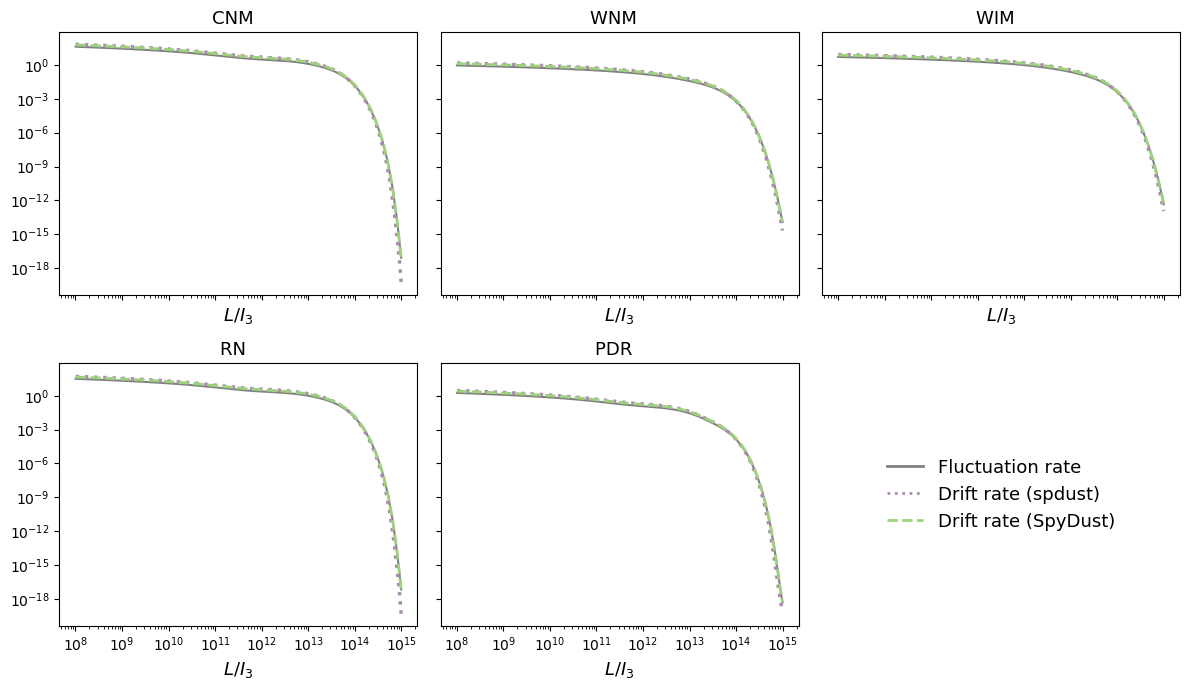

In [12]:
fig, axs = plt.subplots(2, 3, figsize=(12, 7), sharex=True, sharey=True)

# grain size: 3.64e-08 cm - disk-like

plasma_drag_plots(axs[0, 0], CNM_params, 0, "CNM  ")
plasma_drag_plots(axs[0, 1], WNM_params, 0, "WNM  ")
plasma_drag_plots(axs[0, 2], WIM_params, 0, "WIM  ", label=True)
plasma_drag_plots(axs[1, 0], RN_params, 0, "RN  ")
plasma_drag_plots(axs[1, 1], PDR_params, 0, "PDR  ")
axs[1, 2].axis('off')

lines = []
labels = ['Fluctuation rate', 'Drift rate (spdust)', 'Drift rate (SpyDust)']
linestyles = ['-', ':', '--'] 
colors = ["gray", spdust_color2, spy_color1]
for i in range(3):
    line, = axs[1, 2].plot([], [], ls=linestyles[i], label=labels[i], color=colors[i], lw=2)  # Dummy lines for legend
    lines.append(line)

# Place the global legend in the main axis
axs[1, 2].legend(handles=lines, loc="center", frameon=False, fontsize=13, ncol=1)


# Set xsticks fontsize to be 12
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# Set the global legend at the top of the figure; only the legend of the first subplot is shown
plt.tight_layout()

#fig.legend(loc='upper center', bbox_to_anchor=(0.5, 1.06), ncol=3, fontsize=13, frameon=False)
plt.savefig('figures/plasma_drag_comparison.pdf', bbox_inches='tight')



In [13]:
def plot_rot_dist(axis, ind, env, title, plot_xlabel=False, plot_ylabel=False, label=False):
    Min_omega, Max_omega = 1e7, 1e12
    Myomegas = makelogtab(Min_omega, Max_omega, 1000) 
    log_f_omega_new_plasma = spyAngMomDist.log_f_rot(env, a_tab[ind], beta_a_list[ind], spy_fZ[ind], np.array([mu_ip[ind]]), np.array([mu_op[ind]]), tumbling=True, omega_min=Min_omega, omega_max=Max_omega, Nomega=1000, use_spdust_plasma=False)
    log_f_omega_old_plasma = spyAngMomDist.log_f_rot(env, a_tab[ind], beta_a_list[ind], spy_fZ[ind], np.array([mu_ip[ind]]), np.array([mu_op[ind]]), tumbling=True, omega_min=Min_omega, omega_max=Max_omega, Nomega=1000, use_spdust_plasma=True)

    if label:
        axis.loglog(Myomegas, np.exp(log_f_omega_old_plasma[0]), label='Original Plasma Drag', ls='-', lw=2, color=spdust_color2)
        axis.loglog(Myomegas, np.exp(log_f_omega_new_plasma[0]), label='Updated Plasma Drag', ls='--', lw=2, color=spy_color1)
    else:
        axis.loglog(Myomegas, np.exp(log_f_omega_old_plasma[0]), ls='-', lw=2, color=spdust_color2)
        axis.loglog(Myomegas, np.exp(log_f_omega_new_plasma[0]), ls='--', lw=2, color=spy_color1)
 

    if plot_xlabel:
        axis.set_xlabel(r'$\Omega\equiv L/I_{\rm ref}$', fontsize=13)
    if plot_ylabel:
        axis.set_ylabel('Rotation Distribution', fontsize=13)
    axis.set_title(title, fontsize=13)
    #axis.legend(fontsize=12)



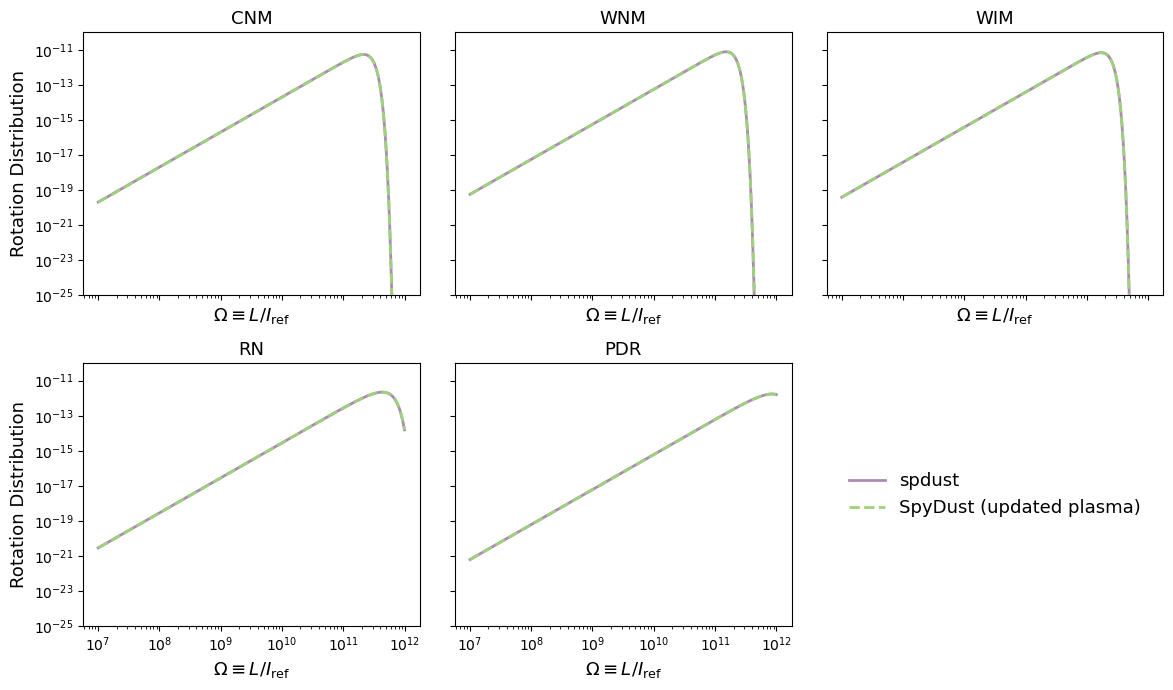

In [14]:
fig, axs = plt.subplots(2, 3, figsize=(12, 7), sharex=True, sharey=True)
#plot_rot_dist(axs[1, 0], -1, WIM_params, "WIM  ", plot_xlabel=True, plot_ylabel=True)
plot_rot_dist(axs[0, 0], 0, CNM_params, "CNM", plot_xlabel=True, plot_ylabel=True)
plot_rot_dist(axs[0, 1], 0, WNM_params, "WNM", plot_xlabel=True)
plot_rot_dist(axs[0, 2], 0, WIM_params, "WIM", plot_xlabel=True)
plot_rot_dist(axs[1,0], 0, RN_params, "RN", plot_xlabel=True, plot_ylabel=True)
plot_rot_dist(axs[1,1], 0, PDR_params, "PDR", plot_xlabel=True)

axs[1, 2].axis('off')

lines = []
labels = ['spdust', 'SpyDust (updated plasma)']
linestyles = ['-', '--'] 
colors = [spdust_color2, spy_color1]
for i in range(2):
    line, = axs[1, 2].plot([], [], ls=linestyles[i], label=labels[i], color=colors[i], lw=2)  # Dummy lines for legend
    lines.append(line)

# Place the global legend in the main axis
axs[1, 2].legend(handles=lines, loc="center", frameon=False, fontsize=13, ncol=1)



plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(1e-25, 1e-10)
plt.tight_layout()

#fig.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=2, fontsize=13, frameon=False)
plt.savefig('figures/rot_dist_comparison.pdf', bbox_inches='tight')

### SED before and after these corrections

In [15]:
from SpyDust.SpyDust import SpyDust
from SpyDust.SPDUST_as_is.spdust import SPDUST

min_freq=1 # in GHz
max_freq=300 # in GHz
n_freq=500

env_list = [DC_params, MC_params, CNM_params, WNM_params, WIM_params, RN_params, PDR_params]
ISM_list = [ 'DC', 'MC', 'CNM', 'WNM', 'WIM', 'RN', 'PDR']

Spy_SED_old_plasma_list = []
Spy_SED_new_plasma_list = []
SPD_SED_list = []

for env in env_list:
    #Spy_SED_old_plasma = SpyDust(env, min_freq=min_freq, max_freq=max_freq, n_freq=n_freq, single_beta=True, spdust_plasma=True)
    Spy_SED_new_plasma = SpyDust(env, min_freq=min_freq, max_freq=max_freq, n_freq=n_freq, single_beta=True, spdust_plasma=False)
    SPD_SED = SPDUST(env, min_freq = min_freq, max_freq=max_freq, n_freq=n_freq)
    #Spy_SED_old_plasma_list.append(Spy_SED_old_plasma)
    Spy_SED_new_plasma_list.append(Spy_SED_new_plasma)
    SPD_SED_list.append(SPD_SED)

mu(1E-7 cm) = 9.3 debye (beta = 0.3845076772265463 debye)
mu(1E-7 cm) = 9.3 debye (beta = 0.3845076772265463 debye)
mu(1E-7 cm) = 9.3 debye (beta = 0.3845076772265463 debye)
mu(1E-7 cm) = 9.3 debye (beta = 0.3845076772265463 debye)
mu(1E-7 cm) = 9.3 debye (beta = 0.3845076772265463 debye)
mu(1E-7 cm) = 9.3 debye (beta = 0.3845076772265463 debye)
mu(1E-7 cm) = 9.3 debye (beta = 0.3845076772265463 debye)


In [16]:
#fractional_diff_list_old_plasma = [ (Spy_SED_old_plasma_list[i+1][1,:]/np.sum(Spy_SED_old_plasma_list[i+1][1,:]))/(SPD_SED_list[i+1][1,:]/np.sum(SPD_SED_list[i+1][1,:])) - 1 
#                                   for i in range(len(env_list)-1)]
#fractional_diff_old_plasma_average = np.mean(np.array(frectional_diff_list_old_plasma), axis=0)

# We avoid the DC environment, because the SED from spdust is numerical 0 at highest frequencies - this causes the fractional difference to be infinite
fractional_diff_list_new_plasma = [ (Spy_SED_new_plasma_list[i+1][1,:]/np.sum(Spy_SED_new_plasma_list[i+1][1,:]))/(SPD_SED_list[i+1][1,:]/np.sum(SPD_SED_list[i+1][1,:])) - 1 
                                   for i in range(len(env_list)-1)]
# We avoid the DC and MC environments, because grains in those environments are assumed not tumbling; so the plasma drag correction is not applied
fractional_diff_new_plasma_average = np.mean(np.array(fractional_diff_list_new_plasma), axis=0)

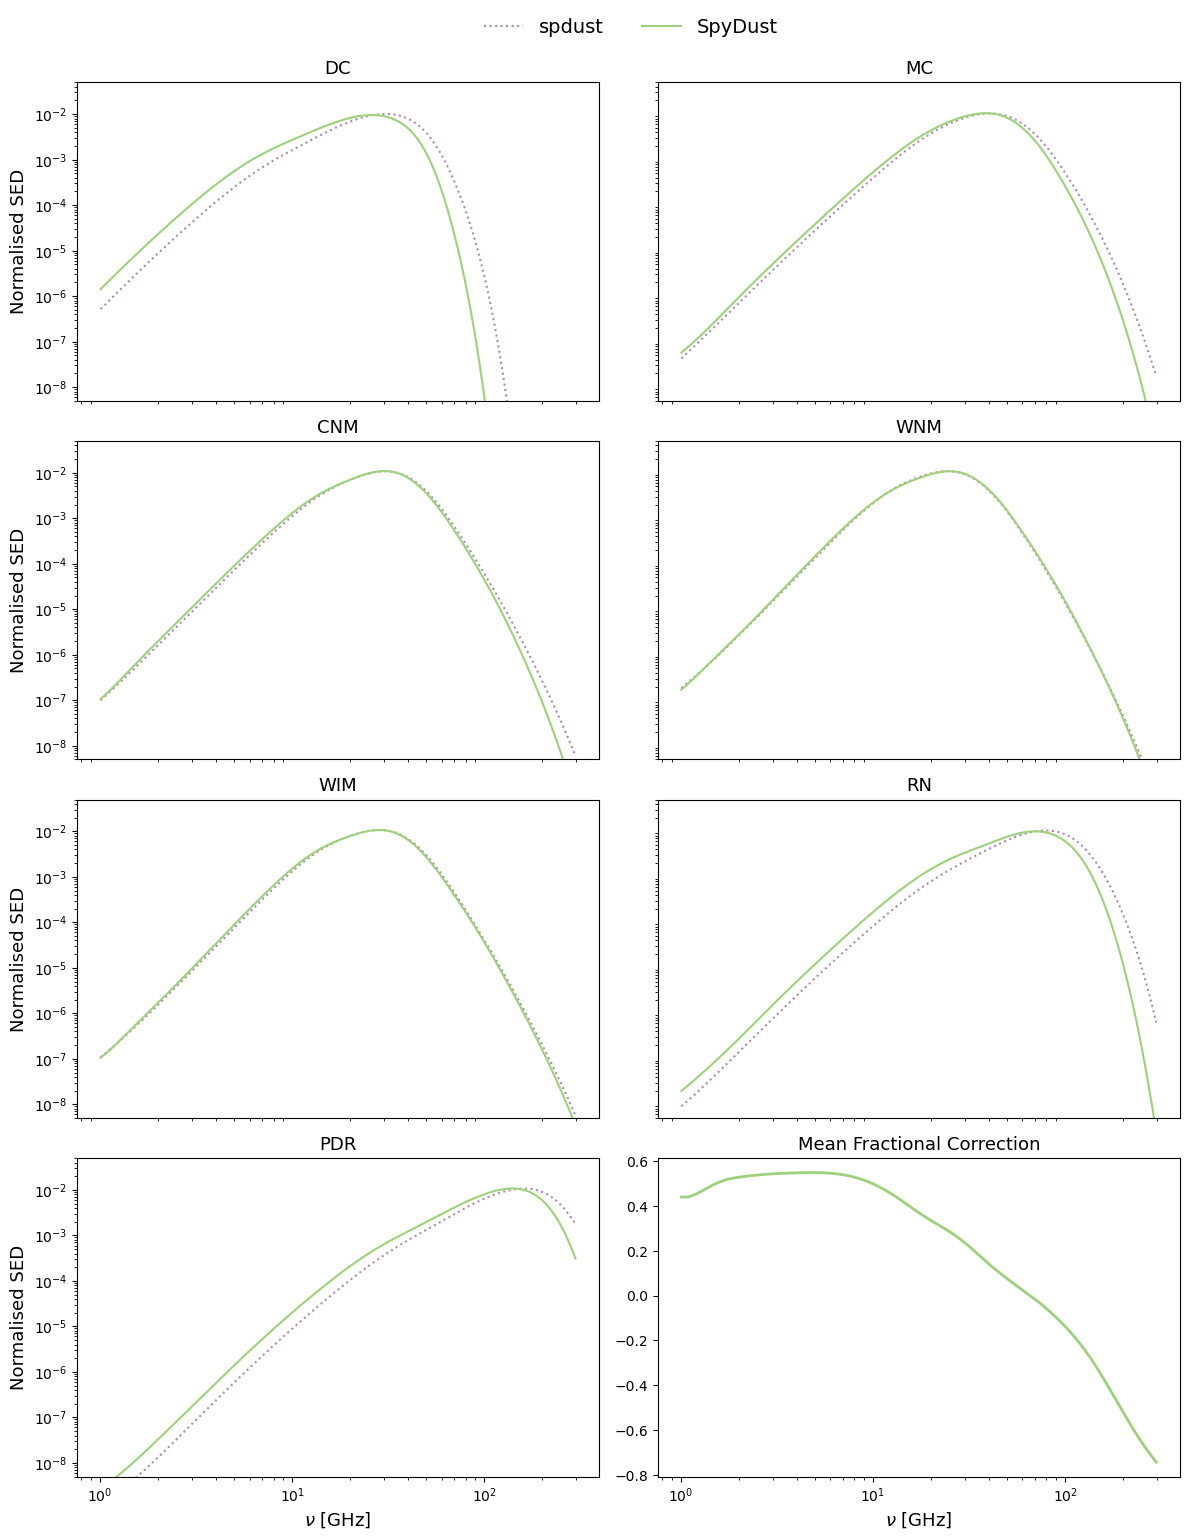

In [17]:
# Create a figure with a 3x3 grid
fig = plt.figure(figsize=(12, 15))
gs = fig.add_gridspec(4, 2)

# First row: single wide plot for title/labels
#main_ax = fig.add_subplot(gs[0, 2])
# main_ax.set_title("Main Title for All Subplots")
#main_ax.axis('off')  # Hide the axis as it's just for title/label space

# Create a dummy plot for the legend
#lines = []
labels = ["spdust", "SpyDust"]
linestyles = [':', '-', '--'] 
colors = [spdust_color2, spy_color1, spy_color2]
#for i in range(3):
#    line, = main_ax.plot([], [], ls=linestyles[i], label=labels[i], color=colors[i])  # Dummy lines for legend
#    lines.append(line)

# Place the global legend in the main axis
#main_ax.legend(handles=lines, loc="center", frameon=False, fontsize=15, ncol=1)

# Define the positions for the 7 subplots in the 3x3 grid
positions = [
    (0, 0), (0, 1),  # Second row
    (1, 0), (1, 1),   # Third row
    (2, 0), (2, 1),
    (3, 0),   
    # Remaining position for the 7th plot
]

def plot_updated_SED(env_ind, ax, title, plot_xlabel=False, plot_ylabel=False, plot_plasma=True):
    #Spy_SED_old_plasma = Spy_SED_old_plasma_list[env_ind]
    Spy_SED_new_plasma = Spy_SED_new_plasma_list[env_ind]
    SPD_SED = SPD_SED_list[env_ind]

    ax.loglog(SPD_SED[0,:], SPD_SED[1,:]/np.sum(SPD_SED[1,:]), ls=linestyles[0], color=colors[0], label=labels[0])
    #ax.loglog(Spy_SED_old_plasma[0,:], Spy_SED_old_plasma[1,:]/np.sum(Spy_SED_old_plasma[1,:]), ls=linestyles[1], color=colors[1], 
    #          label='SpyDust (updated mapping, radiation backreaction)')
    if plot_plasma:
        ax.loglog(Spy_SED_new_plasma[0,:], Spy_SED_new_plasma[1,:]/np.sum(Spy_SED_new_plasma[1,:]), ls=linestyles[1], color=colors[1], 
                  label=labels[1])
    if plot_xlabel:
        ax.set_xlabel(r'$\nu$ [GHz]', fontsize=13)
    else:
        ax.set_xticks([])

    if plot_ylabel:
        ax.set_ylabel('Normalised SED', fontsize=13)
    else:
        ax.set_yticks([])
    # Do not show xticks if plot_xlabel is False

    ax.set_title(title, fontsize=13)
    ax.set_ylim(5e-9, 5e-2)
    #ax.set_xlim(0.9, 255)

# Plot data on each of the 7 subplots
for i, pos in enumerate(positions):
    ax = fig.add_subplot(gs[pos[0], pos[1]])
    plot_xl, plot_yl, plot_pl = False, False, True
    #if i in [0, 1]:
    #    plot_pl = False
    if i in [0, 2, 4, 6]:
        plot_yl = True
    if i in [6]:
        plot_xl = True
    plot_updated_SED(i, ax, ISM_list[i], plot_xlabel=plot_xl, plot_ylabel=plot_yl, plot_plasma=plot_pl)


# Get handles and labels from the specific subplot (ax1)
handles, labels = ax.get_legend_handles_labels()

# Create a figure-level legend using only the handles and labels from ax1
fig.legend(handles, labels,
           loc='upper center', 
           ncol=2,
           columnspacing=2,
           bbox_to_anchor=(0.53, 1.03),
           frameon=False,
           fontsize=14
           )

ax = fig.add_subplot(gs[3, 1])
#plot the fractional corrections
#ax.plot(SPD_SED[0,:], frectional_diff_old_plasma_average, ls=linestyles[1], color=colors[1], lw=2)
ax.plot(SPD_SED[0,:], fractional_diff_new_plasma_average, ls=linestyles[1], color=colors[1], lw=2)
ax.set_xscale('log')
ax.set_xlabel(r'$\nu$ [GHz]', fontsize=13)
ax.set_title('Mean Fractional Correction', fontsize=13)



plt.tight_layout()
plt.savefig('figures/updated_SED_comparison.pdf', bbox_inches='tight')
#plt.xlabel(r'$\nu$ [GHz]')
#plt.title('Normalised SED')
#plt.xlim(1, 200)
#plt.legend()

### If we further consider an ensemble of $\beta$, rather than a single $\beta$ for each `a'

In [18]:
Spy_SED_single_beta_list, Spy_SED_ensemble_beta_list = [], []
for i in range(len(env_list)):
    env = env_list[i]
    if i in [0, 1]:
        sp_plasma = True
    else:
        sp_plasma = False
    Spy_SED_single_beta = Spy_SED_new_plasma_list[i]
    Spy_SED_ensemble_beta = SpyDust(env, min_freq=min_freq, max_freq=max_freq, n_freq=n_freq, single_beta=False, spdust_plasma=sp_plasma)
    #SPD_SED = SPDUST(env, min_freq = min_freq, max_freq=max_freq, n_freq=n_freq)
    Spy_SED_single_beta_list.append(Spy_SED_single_beta)
    Spy_SED_ensemble_beta_list.append(Spy_SED_ensemble_beta)
    #SPD_SED_list.append(SPD_SED)

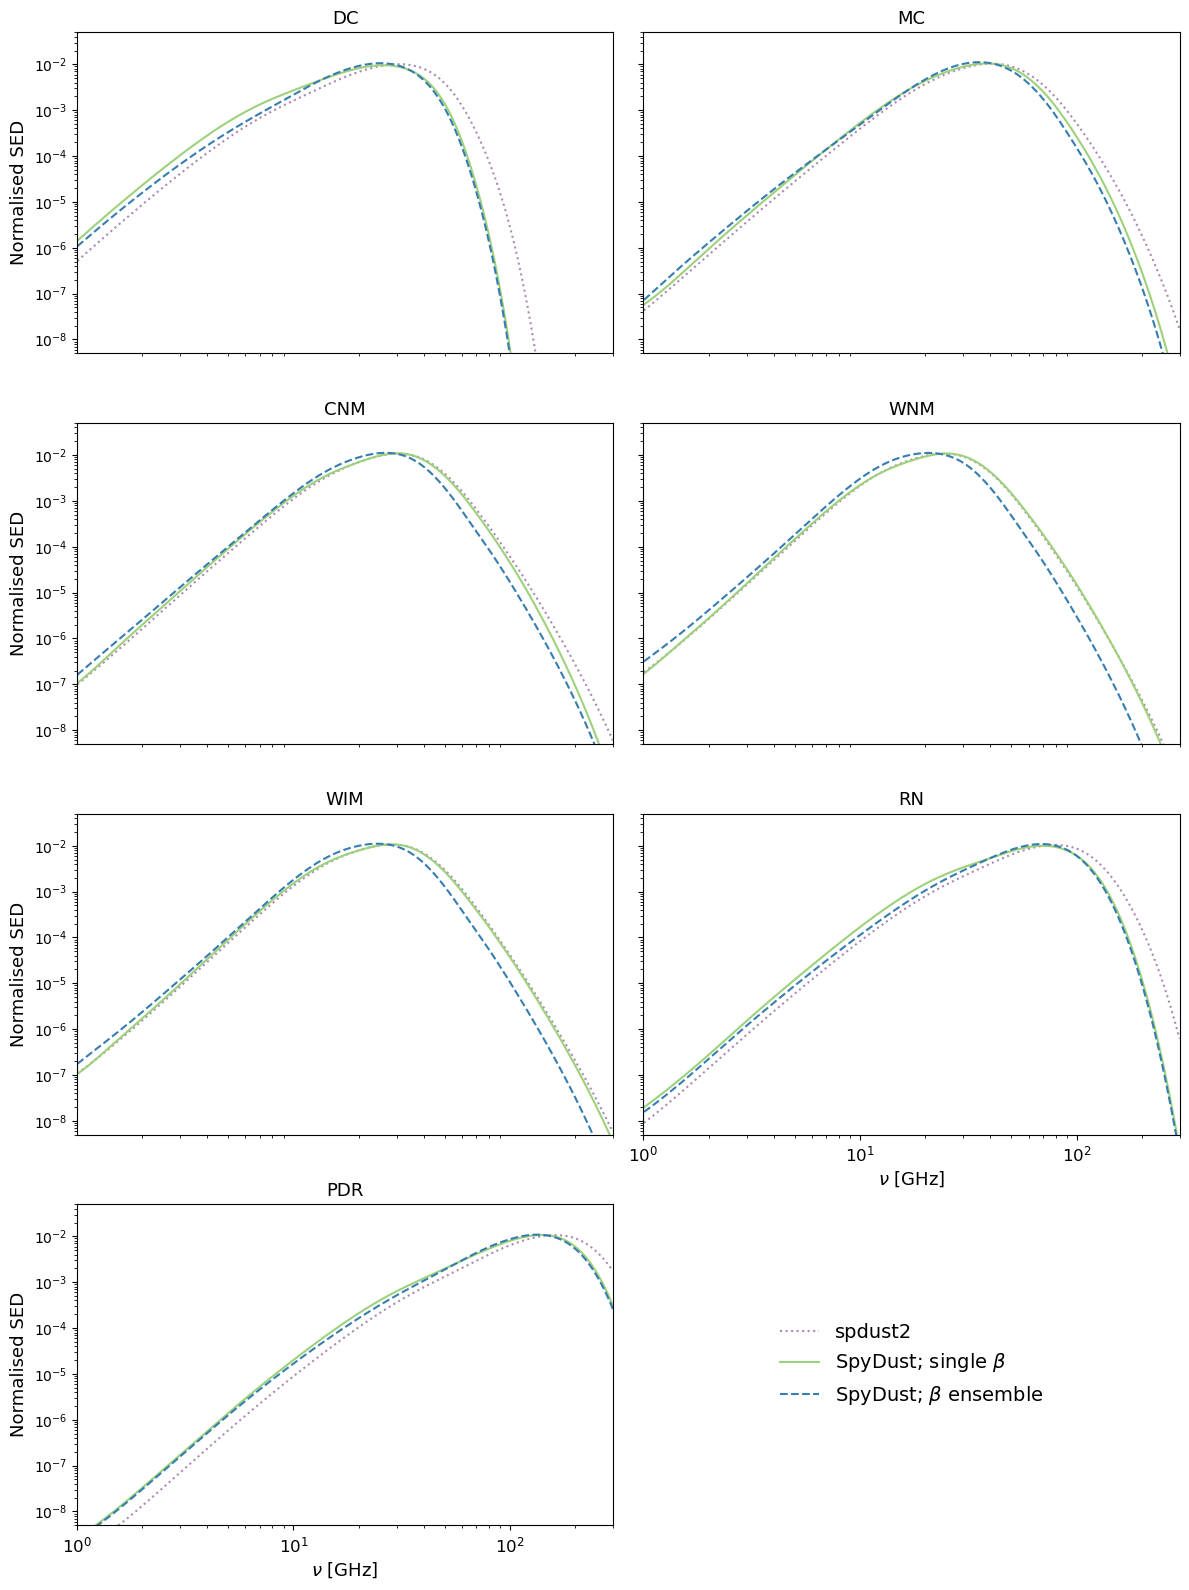

In [19]:
fig, axs = plt.subplots(4, 2, figsize=(12, 16),sharey=True)
def plot_beta_SED(env_ind, ax, title, plot_xlabel=False, plot_ylabel=False, DC=False):
    if DC: # Avoid plotting the high frequency part of the SED for DC environment (those values are numerical 0)
        ax.loglog(SPD_SED_list[env_ind][0,:450], 
                  SPD_SED_list[env_ind][1,:450]/np.sum(SPD_SED_list[env_ind][1,:450]), 
                  ls=linestyles[0], color=colors[0])
        ax.loglog(Spy_SED_single_beta_list[env_ind][0,:450], 
                  Spy_SED_single_beta_list[env_ind][1,:450]/np.sum(Spy_SED_single_beta_list[env_ind][1,:450]), 
                  ls=linestyles[1], color=colors[1])
        ax.loglog(Spy_SED_ensemble_beta_list[env_ind][0,:450], 
                  Spy_SED_ensemble_beta_list[env_ind][1,:450]/np.sum(Spy_SED_ensemble_beta_list[env_ind][1,:450]),
                  ls=linestyles[2], color=colors[2])
    else:
        ax.loglog(SPD_SED_list[env_ind][0,:], SPD_SED_list[env_ind][1,:]/np.sum(SPD_SED_list[env_ind][1,:]), ls=linestyles[0], color=colors[0])
        ax.loglog(Spy_SED_single_beta_list[env_ind][0,:], Spy_SED_single_beta_list[env_ind][1,:]/np.sum(Spy_SED_single_beta_list[env_ind][1,:]), ls=linestyles[1], color=colors[1])
        ax.loglog(Spy_SED_ensemble_beta_list[env_ind][0,:], Spy_SED_ensemble_beta_list[env_ind][1,:]/np.sum(Spy_SED_ensemble_beta_list[env_ind][1,:]), ls=linestyles[2], color=colors[2])
    ax.set_xlim(1, 300)
    if plot_xlabel:
        ax.set_xlabel(r'$\nu$ [GHz]', fontsize=13)
        # set xticks fontsize to be 12
        ax.tick_params(axis='x', labelsize=12)
    else:
        ax.set_xticks([])
    if plot_ylabel:
        ax.set_ylabel('Normalised SED', fontsize=13)
    ax.set_ylim(5e-9, 5e-2)
    ax.set_title(title, fontsize=13)

plot_beta_SED(0, axs[0, 0], 'DC', plot_ylabel=True, DC=True)
plot_beta_SED(1, axs[0, 1], 'MC')
plot_beta_SED(2, axs[1, 0], 'CNM', plot_ylabel=True)
plot_beta_SED(3, axs[1, 1], 'WNM')
plot_beta_SED(4, axs[2, 0], 'WIM', plot_ylabel=True)
plot_beta_SED(5, axs[2, 1], 'RN', plot_xlabel=True)
plot_beta_SED(6, axs[3, 0], 'PDR', plot_xlabel=True, plot_ylabel=True)
axs[3, 1].axis('off')
# Create a dummy plot in axs[3,1] for the legend
lines = []
beta_labels = ['spdust2', 'SpyDust; single $\\beta$', 'SpyDust; $\\beta$ ensemble']
for i in range(3):
    line, = axs[3, 1].plot([], [], ls=linestyles[i], color=colors[i], label=beta_labels[i])
    lines.append(line)
axs[3, 1].legend(handles=lines, loc='center', fontsize=14, frameon=False)  
plt.tight_layout()
plt.savefig('figures/beta_SED_comparison.pdf', bbox_inches='tight')

